## Criminality Across Vancouver Neighbourhoods

By: Isabela Lucas Bruxellas, Sam Thorne, Sean Meng

### Introduction

#### Background Information

Despite nationwide crime rates declining since the 1990s in Canada (STATCAN 2021), many Canadians still fear crime, especially in their local communities (JUSTICE CANADA, 2022). Current research suggests that effective crime control strategies embrace the importance of regular citizens in preventing crime and enhance their ability to do so (USCIDA et al., 2014). This research focuses on empowering citizens by providing an understanding of overall and crime-specific proportions across the communities of Vancouver. This analysis will infer which districts in Vancouver have proportionally higher and lower crime rates.



#### Research Question

Is there a difference between the average annual proportion of crimes in Vancouver across different districts? 

To answer this question, we will explore the proportion of crimes grouped per year from **2003** to **2022** and across the **Central**, **East**, **South** and **West** districts of Vancouver. We will calculate the mean proportion of crime that lies in each district annually and find the interquartile range. We will also analyze trends for different crime types to explore whether there are significant pattern changes.

#### The Dataset

The dataset is provided by the Vancouver Police Department (VDC) and was collected from the PRIME BC Police Records Management System (RMS)on October 21st, 2022. This data reflects all police-reported crimes during the period. The dataset includes crime **type**, **time**, and **location**.

### Preliminary Results

In [2]:
set.seed(101)

library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




#### Data import and cleaning

In [6]:
# Download the data from the original provided dataset website, and upload it to an open GitHub repository,
# Then read in data by the URL of that open GitHub repository.
crimedata <- read_csv('https://raw.githubusercontent.com/samnthorne/STAT201_Group40/main/crimedata_csv_AllNeighbourhoods_AllYears.csv')
head(crimedata) 

Rows: 841759 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166


We only require the `YEAR` and `NEIGHBOURHOOD` columns and remove any rows containing NA values. We keep the `TYPE` column for further analysis. We will compare crime rates in the four districts of Vancouver instead of neighbourhoods for simplicity. We define the districts via the `NEIGHBOURHOOD` column with reference to Globe Media Ltd. (2022). 

In [6]:
# Dropping unnecessary columns and filtering out NA values.
selected_crimedata <- crimedata %>%
    select('YEAR', 'NEIGHBOURHOOD', 'TYPE') %>%
    filter(!is.na(NEIGHBOURHOOD)) %>%
    filter(!is.na(YEAR)) # drop NA values in the neighbourhood column and in the year column. 

# defining the districts of Vancouver. 
central = c('Central Business District', 'Stanley Park', 'West End')
west = c('Fairview', 'Kitsilano', 'West Point Grey',  
        'Shaughnessy', 'Musqueam', 'Arbutus Ridge', 'South Cambie', 'Oakridge')
east = c('Grandview-Woodland', 'Mount Pleasant', 'Kensington-Cedar Cottage',
         'Riley Park', 'Strathcona', 'Hastings-Sunrise', 'Killarney')
south = c('Dunbar-Southlands', 'Kerrisdale', 'Marpole','Sunset', 'Victoria-Fraserview', 
          'Renfrew-Collingwood','Killarney')

# Creating a new column in the data frame of district
# value can be Central, West, East, or South depending on neighbourhood
# Can drop the neighbourhood column here too as from here onwards we will exclusively look at district.
district_crimedata <- selected_crimedata %>%
    mutate(DISTRICT = case_when(
        NEIGHBOURHOOD == 'Central Business District' | NEIGHBOURHOOD == 'Stanley Park' | NEIGHBOURHOOD == 'West End' ~ 'Central',
        NEIGHBOURHOOD == 'Fairview' | NEIGHBOURHOOD == 'Kitsilano'| NEIGHBOURHOOD =='West Point Grey'|
        NEIGHBOURHOOD == 'Shaughnessy'| NEIGHBOURHOOD == 'Musqueam'|
        NEIGHBOURHOOD == 'Arbutus Ridge'| NEIGHBOURHOOD == 'South Cambie' | NEIGHBOURHOOD == 'Oakridge' ~ 'West',
        NEIGHBOURHOOD == 'Grandview-Woodland'| NEIGHBOURHOOD == 'Mount Pleasant'| 
        NEIGHBOURHOOD == 'Kensington-Cedar Cottage'| NEIGHBOURHOOD == 'Riley Park'| NEIGHBOURHOOD == 'Strathcona'|
        NEIGHBOURHOOD == 'Hastings-Sunrise' ~ 'East',
        NEIGHBOURHOOD == 'Dunbar-Southlands'|NEIGHBOURHOOD == 'Kerrisdale' | NEIGHBOURHOOD == 'Marpole'|NEIGHBOURHOOD == 'Sunset'|
        NEIGHBOURHOOD == 'Victoria-Fraserview'|NEIGHBOURHOOD == 'Renfrew-Collingwood'|NEIGHBOURHOOD == 'Killarney'~'South')) %>%
    select(-NEIGHBOURHOOD)
    # filter(is.na(DISTRICT)) # use to make sure every neighbourhood in the data has been included.

# the minimum year in this data is 2003 so this is how far back we will be looking.
print(paste("The first year to be included in our analysis is", min(crimedata$YEAR)))
# 2021 will be the maximum year in our data as 2022 has not finished yet so it's numbers are not
# representative of an entire year of crime.

# removing the year 2022 from the data
year_crime_data <- district_crimedata %>%
    filter(YEAR != 2022)

# Next we grouped the type of crime into more broad categories than what is in the original data set.
# We also removed car accident type to reduce noise. We determined it was unnnecessary when trying to 
# determine the safest district in regards to crime.
crime_data <- year_crime_data %>%
    mutate(TYPE = case_when(
        TYPE == "Break and Enter Commercial"|TYPE == "Break and Enter Residential/Other" ~ "Break and Enter",
        TYPE == "Other Theft"|TYPE == "Theft from Vehicle"|TYPE == "Theft of Bicycle"|TYPE == "Theft of Vehicle" ~ "Theft",
        TYPE == 'Homicide' ~ 'Homicide', TYPE == 'Mischief'~'Mischief', TYPE == 'Offence Against a Person'~'Offence Against a Person')) %>%
    filter(!is.na(TYPE))

print("This is a piece of the wrangled data frame")
head(crime_data)

[1] "The first year to be included in our analysis is 2003"
[1] "This is a piece of the wrangled data frame"


YEAR,TYPE,DISTRICT
<dbl>,<chr>,<chr>
2012,Break and Enter,West
2019,Break and Enter,West
2019,Break and Enter,Central
2021,Break and Enter,Central
2014,Break and Enter,Central
2020,Break and Enter,Central


#### Data Plots

We will visualize the distribution of crime in all four districts of Vancouver from 2003 to 2021. The stacks in the bar graph also colour-code the types of crimes for further analysis.

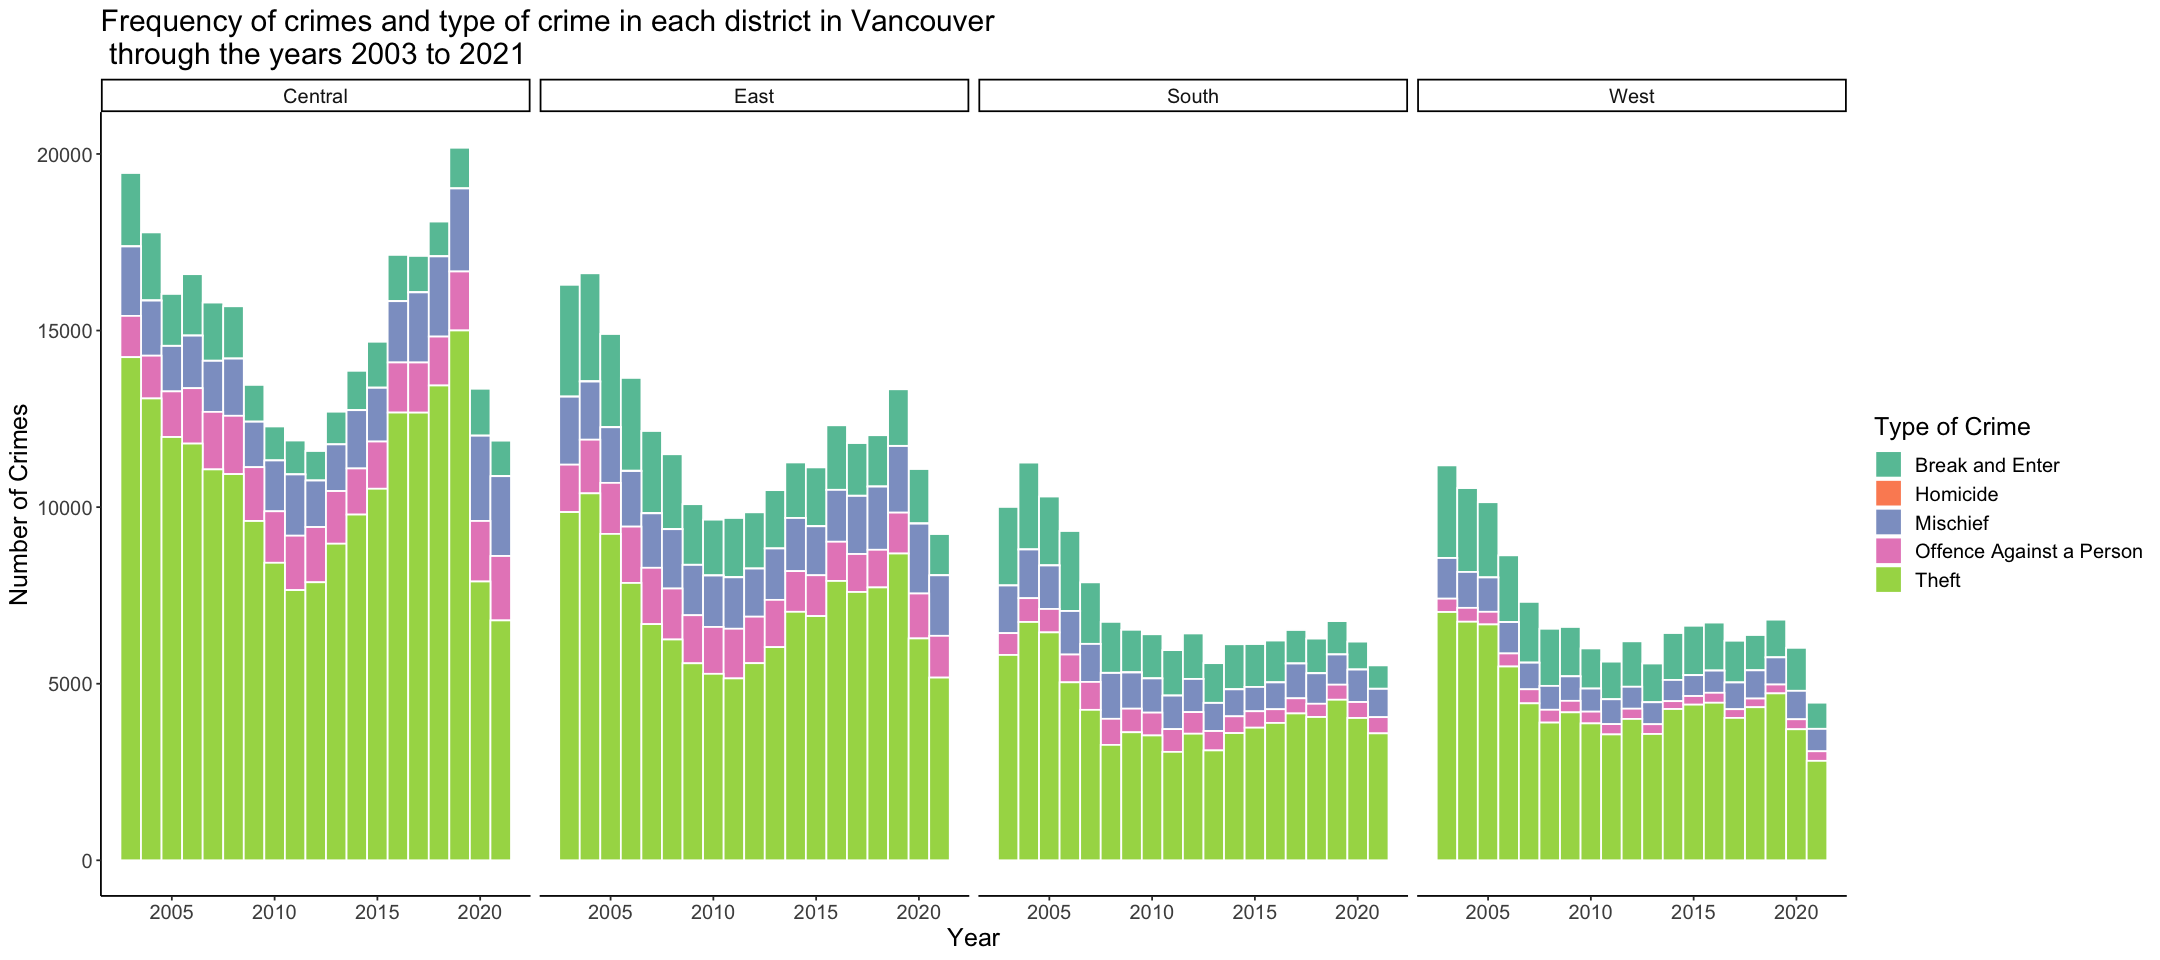

In [7]:
options(repr.plot.width = 18, repr.plot.height = 8)

years_vis <- crime_data %>%
    ggplot(aes(x = YEAR, fill = TYPE))+
    geom_histogram(binwidth = 1, color = 'white')+
    theme_classic() +
    theme(legend.position="right", 
          text = element_text(size = 15)) +
    labs(title = "Frequency of crimes and type of crime in each district in Vancouver \n through the years 2003 to 2021",
         x = "Year",
         y = "Number of Crimes",
         fill = "Type of Crime")+
    facet_wrap(~DISTRICT, ncol = 4)+
    scale_fill_brewer(palette = 'Set2') # colorblind friendly palette.
years_vis

#### Estimates

We should calculate the proportion of crime in each district per year, then calculate the average proportion of crime in each district from 2003 to 2021.

In [8]:
# Added another column to the data which holds the proportion of crime for the corresponding district and year
# of the row.
prop_data <- crime_data %>%
    group_by(YEAR) %>%
    mutate(num_year = n()) %>%
    ungroup() %>%
    group_by(YEAR, DISTRICT) %>%
    mutate(PROP = n()/num_year) %>%
    select(-num_year)

# Using the proportion found above, find the mean over all years for each district.
estimation_table <- prop_data %>%
    group_by(DISTRICT) %>%
    summarise(MEAN_PROP = mean(PROP))

print("This table contains the average annual proportion of Vancouver crime in each district")
estimation_table

[1] "This table contains the average annual proportion of Vancouver crime in each district"


DISTRICT,MEAN_PROP
<chr>,<dbl>
Central,0.3710028
East,0.2888026
South,0.1748564
West,0.1719381


### Methods

#### Trustworthiness of Report

As a result, it is trustworthy and unbiased because it contains all police-reported crimes in Vancouver. One limitation of this dataset is that it does not reflect the full population of crimes (unreported), but this study only focuses on researching police-reported crime statistics. 

#### Comment on Preliminary Results and Research Methodology 

The preliminary results only provide an overview of the mean crime proportions. Though interesting insights can be derived from the plots, we still need to advance the statistical analysis of the topic to answer the research question conclusively: 

We need a hypothesis test at a significance level of a = 0.05 to determine if there is a difference between the average annual proportion of crimes in different districts of Vancouver.

Let c = central, w = west, s = south, e = east

H0: pc = pw = ps = pe

H1: at least one {pc, pw, ps, pe} is different from the others

We will also conduct ANOVA tests to determine whether the differences between the four groups are statistically significant. So the test will analyze the levels of variance within the groups by taking samples from each of them.

#### Expectations

Based on the insights from the preliminary results, we expect to find statistically significant differences in the mean crime proportion both through the entire time range and each year individually.

#### Contribution to the scholarly community

We could not find any studies about police-reported crime rates in BC that take a micro-focused look into the districts of Vancouver and attempt to determine differences in mean crime proportion. Therefore, we believe this study could contribute to  further analysis of criminality from a community perspective. Deeper insight into crime rates across the Vancouver districts will inform citizens (as advocates for their communities) about the realities of their region, empowering them to use this information for political and community-building purposes.

### References


(STATCAN, 2021) https://www150.statcan.gc.ca/n1/pub/85-002-x/2022001/article/00013-eng.htm

(JUSTICE CANADA, 2022) https://www.justice.gc.ca/eng/rp-pr/csj-sjc/crime/rr01_1/p0.html

(GLOBE MEDIA LTD., 2022) https://www.expatarrivals.com/americas/canada/vancouver/areas-and-suburbs-vancouver

(USCIDA et al., 2014) https://www.ojp.gov/pdffiles1/nij/grants/245408.pdf